# A sample of plots

The idea of this notebook is to show off a number of plot types, and act as a simple check of the plotting output. It requires `matplotlib` and does not attempt to describe the plots (see the help for the plot constructor for this!).

In [1]:
import numpy as np

%matplotlib inline

In [2]:
from sherpa import data
from sherpa.astro import data as astrodata

from sherpa import plot
from sherpa.astro import plot as astroplot

## One dimensional data plots

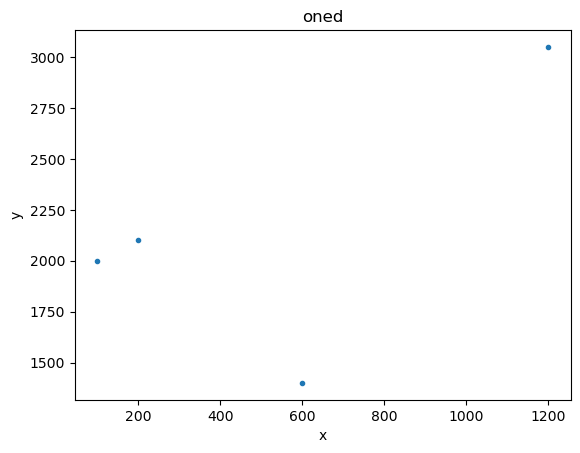

In [3]:
x1 = [100, 200, 600, 1200]
y1 = [2000, 2100, 1400, 3050]

d1 = data.Data1D('oned', x1, y1)

plot1 = plot.DataPlot()
plot1.prepare(d1)
plot1.plot()

We can have some fun with the plot options (these are a mixture of generic options, such as `xlog`, and ones specific to the plotting backend - which here is `matplotlib` - such as `marker`).

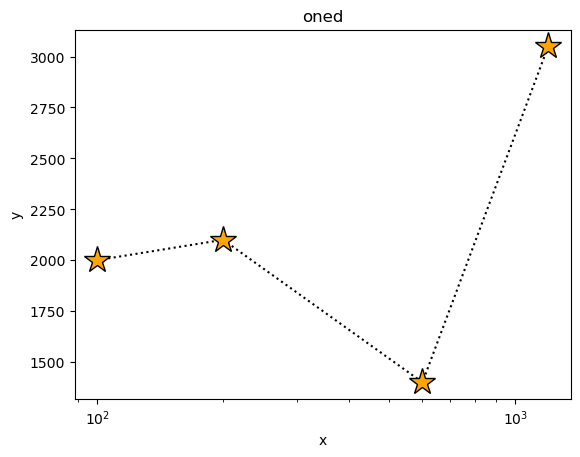

In [4]:
plot1.plot(xlog=True, linestyle='dotted', marker='*', markerfacecolor='orange', markersize=20, color='black')

The plot object contains the preferences - here we look at the default plot settings. Note that some plot types have different - and even multiple - preference settings.

In [5]:
plot.DataPlot.plot_prefs

{'xlog': False,
 'ylog': False,
 'label': None,
 'xerrorbars': False,
 'yerrorbars': True,
 'color': None,
 'linestyle': 'None',
 'linewidth': None,
 'marker': '.',
 'alpha': None,
 'markerfacecolor': None,
 'markersize': None,
 'ecolor': None,
 'capsize': None}

Error bars - here on the dependent axis - can be displayed too:

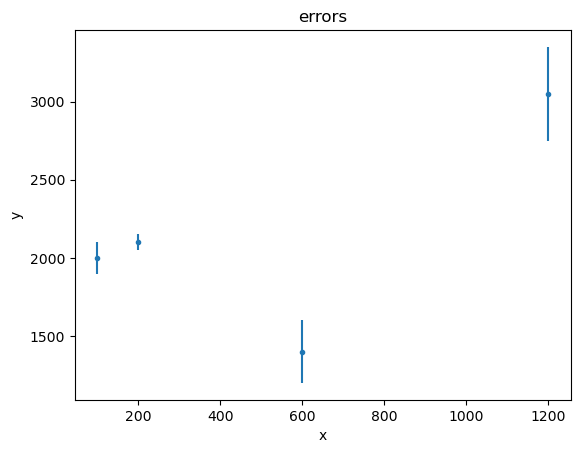

In [6]:
dy1 = [100, 50, 200, 300]
d2 = data.Data1D('errors', x1, y1, dy1)

plot2 = plot.DataPlot()
plot2.prepare(d2)

plot2.plot()

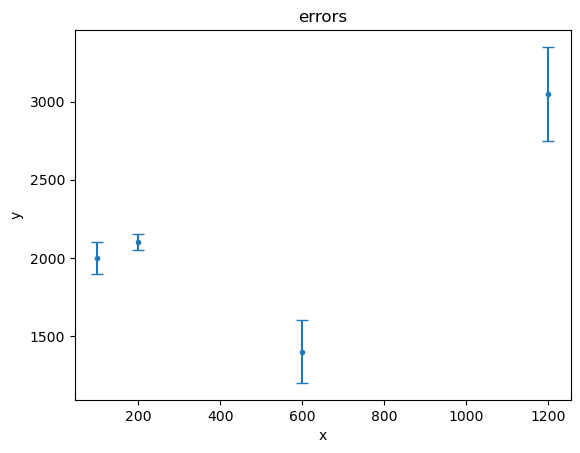

In [7]:
plot2.plot(capsize=4)

Histogram-style data (with low and high edges) are handled similarly:

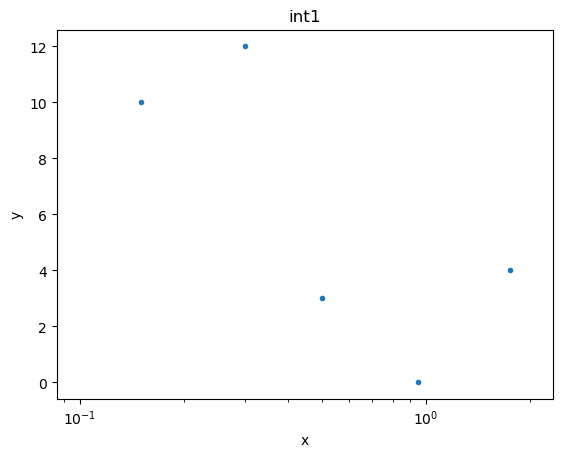

In [8]:
xlo2 = [0.1, 0.2, 0.4, 0.8, 1.5]
xhi2 = [0.2, 0.4, 0.6, 1.1, 2.0]
y2 = [10, 12, 3, 0, 4]

data3 = data.Data1DInt('int1', xlo2, xhi2, y2)

plot3 = plot.DataHistogramPlot()
plot3.prepare(data3)
plot3.plot(xlog=True)

If we want to see the data drawn "like a histogram" then we need to set the `linestyle` attribute:

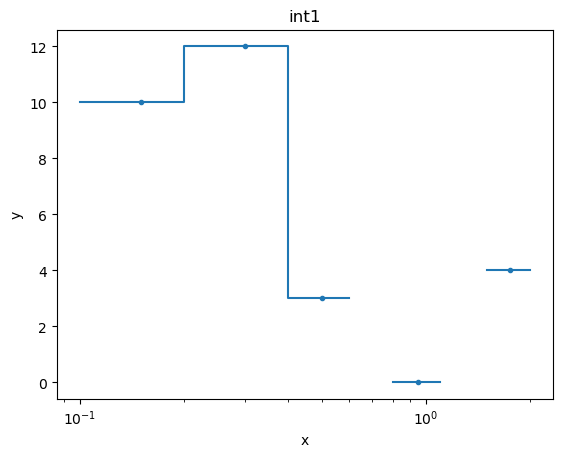

In [9]:
plot3.plot(xlog=True, linestyle='solid')

The histogram-style plots are an example of a plot using a different name for the preference settings, in this case `histo_prefs`:

In [10]:
plot.DataHistogramPlot.histo_prefs

{'xlog': False,
 'ylog': False,
 'label': None,
 'xerrorbars': False,
 'yerrorbars': True,
 'color': None,
 'linestyle': 'None',
 'linewidth': None,
 'marker': '.',
 'alpha': None,
 'markerfacecolor': None,
 'markersize': None,
 'ecolor': None,
 'capsize': None}

Previously we explicitly set the error values, but we can also use one of the chi-square statistics to come up with error values. In this case it's just the square-root of the data value (so, for $x \sim 1$ bin, we have an error of 0):

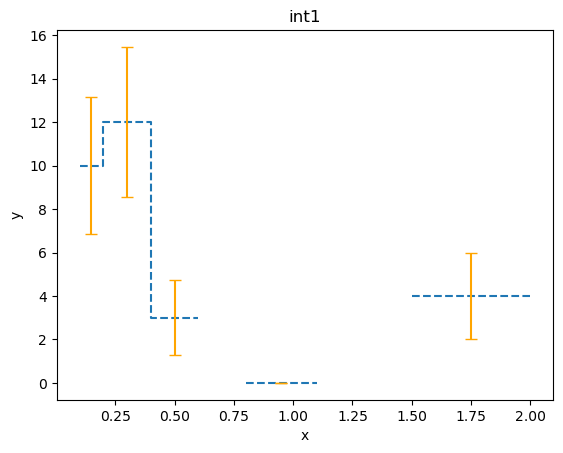

In [11]:
from sherpa.stats import Chi2DataVar

plot4 = plot.DataHistogramPlot()
plot4.prepare(data3, stat=Chi2DataVar())
plot4.plot(linestyle='dashed', marker=None, ecolor='orange', capsize=4)

## PHA-related plots

We start with an ARF from a rather simple instrument. This time we also use the `SplitPlot` class to create multiple plots (although this could be done just as easily with `matplotlib` functions):

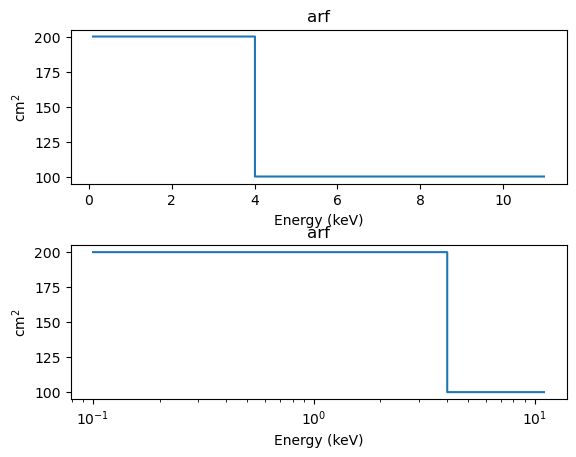

In [12]:
energies = np.arange(0.1, 11, 0.01)
elo = energies[:-1]
ehi = energies[1:]

arf = 100 * np.ones_like(elo)
arf[elo < 4] = 200

darf = astrodata.DataARF('arf', elo, ehi, arf)
aplot = astroplot.ARFPlot()
aplot.prepare(darf)

splot = plot.SplitPlot()

splot.addplot(aplot)
splot.addplot(aplot, xlog=True)

The preferences for the split plot are empty by default, because there are no backend-independent settings:

In [13]:
splot.plot_prefs

{}

However, here we are using matplotlib and we can get "hspace" "wspace" etc as in [plt.subplots_adjust](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html) to tweak the plot layout:

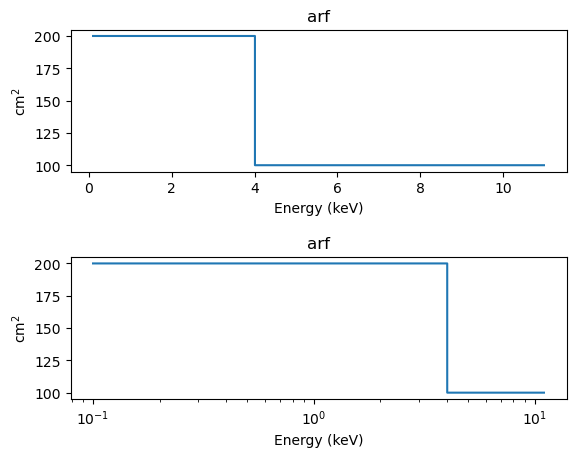

In [14]:
splot.reset()
splot.plot_prefs['hspace'] = 0.6

splot.addplot(aplot)
splot.addplot(aplot, xlog=True)

A PHA, which matches the ARF, can be created (with a sinusoidal pattern just to show something different):

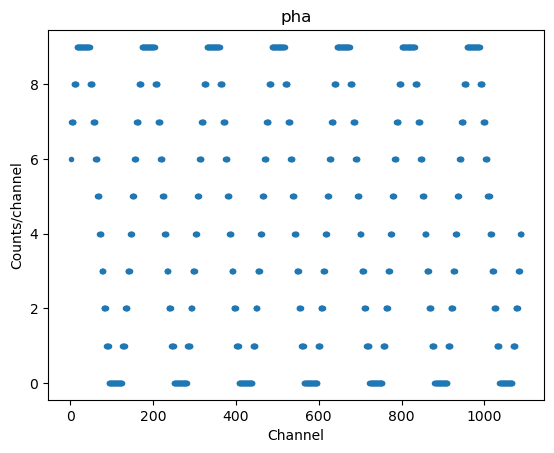

In [15]:
chans = np.arange(1, len(elo) + 1, dtype=np.int16)
counts = 5 + 5 * np.sin(elo * 4)
counts = counts.astype(int)

dpha = astrodata.DataPHA('pha', chans, counts)

pplot = astroplot.DataPHAPlot()
pplot.prepare(dpha)

pplot.plot()

Adding the ARF to the data allows us to change to `energy` units:

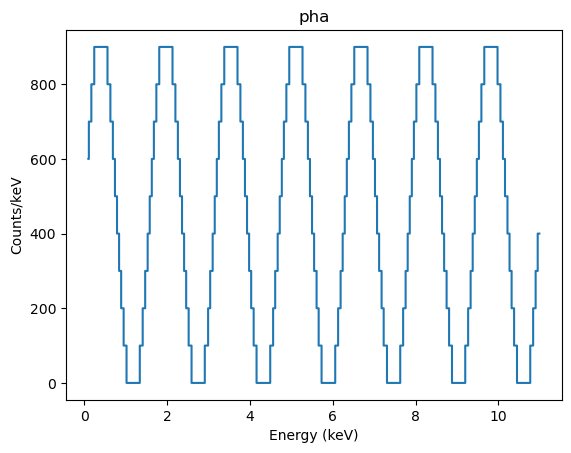

In [16]:
dpha.set_arf(darf)
dpha.set_analysis('energy')

pplot.prepare(dpha)
pplot.plot(linestyle='solid', marker=None)

Grouping the data - in this case in 20-channel groups - allows us to check the "x errorbar" handling (the 'errors' here just indicate the bin width, and so match the overplotted orange line):

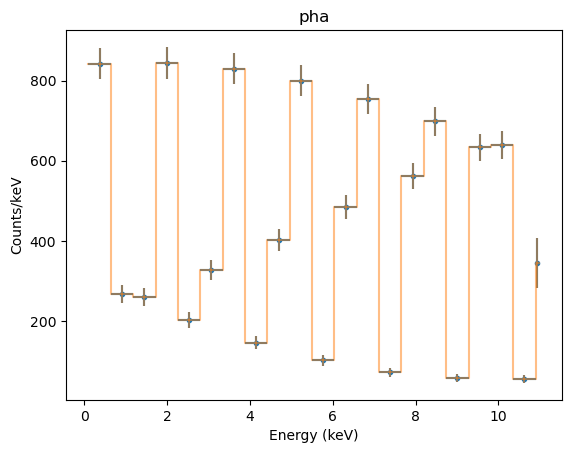

In [17]:
dpha.group_bins(20)

pplot.prepare(dpha, stat=Chi2DataVar())
pplot.plot(xerrorbars=True, yerrorbars=True)
pplot.overplot(linestyle='solid', alpha=0.5, marker=None)

We can see how a model looks for this dataset - in this case a simple sinusoidal model which is multiplied by the ARF (shown earlier), and so is not going to match the data.

In [18]:
from sherpa.models.basic import Sin
from sherpa.astro.instrument import Response1D

mdl = Sin()
mdl.period = 4

# Note that the response information - in this case the ARF and channel-to-energy mapping - needs
# to be applied to the model, which is done by the Response1D class in this example.
#
rsp = Response1D(dpha)
full_model = rsp(mdl)
print(full_model)

apply_arf(sin)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   sin.period   thawed            4        1e-10           10           
   sin.offset   thawed            0            0  3.40282e+38           
   sin.ampl     thawed            1        1e-05  3.40282e+38           


Note that the `ModelHistogram` class does not use the grouping of the PHA dataset, so it shows the model evaluated per channel:

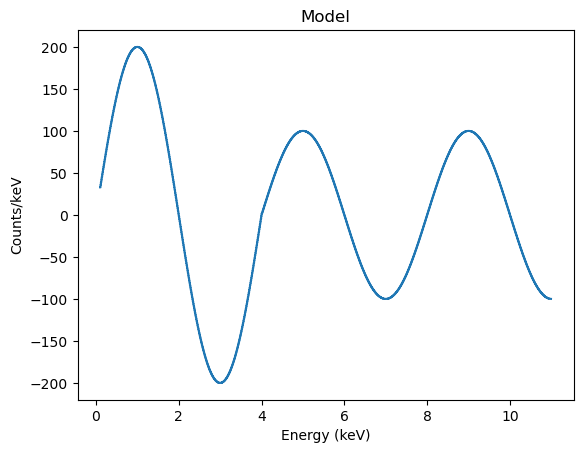

In [19]:
mplot = astroplot.ModelHistogram()
mplot.prepare(dpha, full_model)

mplot.plot()

The discontinuity at 4 keV is because of the step function in the ARF (200 cm$^2$ below this energy and 100 cm$^2$ above it).

The `ModelPHAHistogram` class does group the model to match the data:

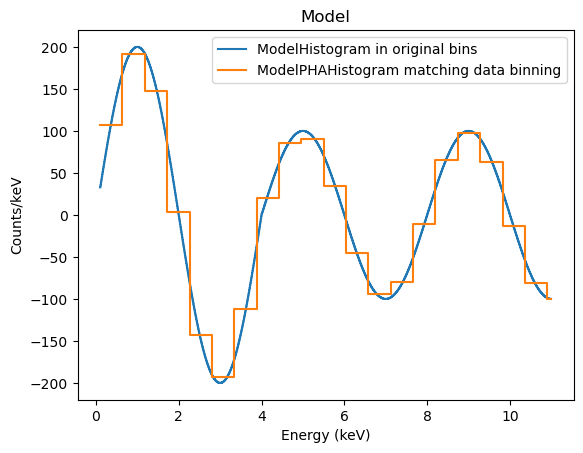

In [20]:
mplot2 = astroplot.ModelPHAHistogram()
mplot2.prepare(dpha, full_model)

mplot.plot(label='ModelHistogram in original bins')
mplot2.overplot(label='ModelPHAHistogram matching data binning')

## Object-less plots

There are a number of plot classes that don't need a data object, such as scatter plots:

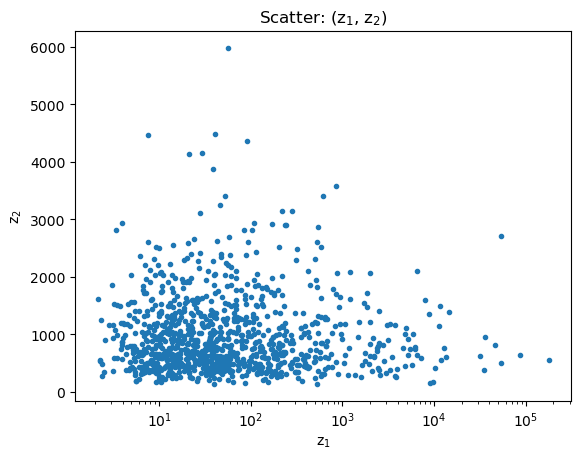

In [21]:
np.random.seed(1273)

# I've never used the Wald distribution before, so let's see how it looks...
#
z1 = np.random.wald(1000, 20, size=1000)
z2 = np.random.wald(1000, 2000, size=1000)

splot = plot.ScatterPlot()
splot.prepare(z1, z2, xlabel='z$_1$', ylabel='z$_2$', name='(z$_1$, z$_2$)')
splot.plot(xlog=True)

and cumulative plots:

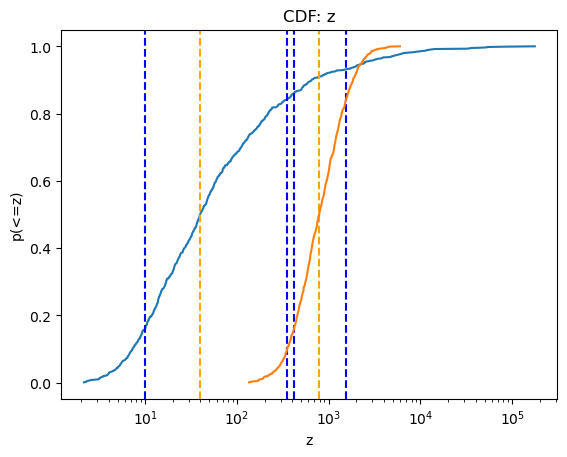

In [22]:
cplot = plot.CDFPlot()

cplot.prepare(z1, xlabel='z', name='z')
cplot.plot(xlog=True)

cplot.prepare(z2)
cplot.overplot()

Note that this is a small sampling of the available plot types (although most are variants of plotting either the data or a model).